### Use this Jupyter Notebook as a guide to run your trained model in inference mode

created by Anton Morgunov

inspired by [tensorflow object detection API tutorial](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#exporting-a-trained-model)

Your first step is going to specify which unit you are going to work with for inference. Select between GPU or CPU and follow the below instructions for implementation.

In [2]:
!source venv/bin/activate

In [3]:
import os # importing OS in order to make GPU visible
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # do not change anything in here

# specify which device you want to work on.
# Use "-1" to work on a CPU. Default value "0" stands for the 1st GPU that will be used
os.environ["CUDA_VISIBLE_DEVICES"]="0" # TODO: specify your computational device

In [4]:
import tensorflow as tf # import tensorflow

# checking that GPU is found
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

2022-10-28 11:23:37.886248: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU found


2022-10-28 11:23:39.220736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 11:23:39.794794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 47219 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:15:00.0, compute capability: 7.5


In [37]:
# other import
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm

%matplotlib inline

Next you will import import scripts that were already provided by Tensorflow API. **Make sure that "Tensorflow" is your current working directory.**

In [6]:
import sys # importyng sys in order to access scripts located in a different folder

path2scripts = 'models/research/' # TODO: provide path to the research folder
sys.path.insert(0, path2scripts) # making scripts in models/research available for import

path2models = '<OBFUSCATED>/models'
sys.path.insert(0, path2models)

['/home/leitat/github-repos/atenea/WindPro/Dron_Surface_Damage_Inspection/Tensorflow/models', 'models/research/', '/home/leitat/github-repos/atenea/WindPro/Dron_Surface_Damage_Inspection/Tensorflow', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/leitat/jupyter/lib/python3.8/site-packages', '/home/leitat/jupyter/src/taming-transformers', '/home/leitat/jupyter/src/clip', '/home/leitat/github-repos/atenea/Dreambooth-Stable-Diffusion']


In [17]:
# importing all scripts that will be needed to export your model and use it for inference
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

Now you can import and build your trained model:

In [18]:
# NOTE: your current working directory should be Tensorflow.

# TODO: specify two pathes: to the pipeline.config file and to the folder with trained model.
path2config ='workspace/exported_models/efficientdet_d0/v1/pipeline.config'
path2model = 'workspace/exported_models/efficientdet_d0/v1/'

In [19]:
# do not change anything in this cell
configs = config_util.get_configs_from_pipeline_file(path2config) # importing config
model_config = configs['model'] # recreating model config
detection_model = model_builder.build(model_config=model_config, is_training=False) # importing model

2022-10-28 12:24:04.394956: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47219 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:15:00.0, compute capability: 7.5


In [21]:
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(path2model, 'checkpoint/ckpt-0')).expect_partial()

Next, path to label map should be provided. Category index will be created based on label map file

In [22]:
path2label_map = 'workspace/data/label_map.pbtxt' # TODO: provide a path to the label map file
category_index = label_map_util.create_category_index_from_labelmap(path2label_map,use_display_name=True)

Now, a few supporting functions will be defined

In [23]:
def detect_fn(image):
    """
    Detect objects in image.
    
    Args:
      image: (tf.tensor): 4D input image
      
    Returs:
      detections (dict): predictions that model made
    """

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

In [24]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      numpy array with shape (img_height, img_width, 3)
    """
    
    return np.array(Image.open(path))

**Next function is the one that you can use to run inference and plot results an an input image:**

In [39]:
def inference_with_plot(path2images, box_th=0.25):
    """
    Function that performs inference and plots resulting b-boxes
    
    Args:
      path2images: an array with pathes to images
      box_th: (float) value that defines threshold for model prediction.
      
    Returns:
      None
    """
    for image_path in path2images:

        print('Running inference for {}... '.format(image_path), end='')

        image_np = load_image_into_numpy_array(image_path)
        
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)

        # All outputs are batches tensors.
        # Convert to numpy arrays, and take index [0] to remove the batch dimension.
        # We're only interested in the first num_detections.
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                      for key, value in detections.items()}
        
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=200,
                min_score_thresh=box_th,
                agnostic_mode=False,
                line_thickness=2)

        plt.figure(figsize=(15,10))
        plt.imshow(image_np_with_detections)
        print('Done')
    plt.show()

Next, we will define a few other supporting functions:

In [26]:
def nms(rects, thd=0.5):
    """
    Filter rectangles
    rects is array of oblects ([x1,y1,x2,y2], confidence, class)
    thd - intersection threshold (intersection divides min square of rectange)
    """
    out = []

    remove = [False] * len(rects)

    for i in range(0, len(rects) - 1):
        if remove[i]:
            continue
        inter = [0.0] * len(rects)
        for j in range(i, len(rects)):
            if remove[j]:
                continue
            inter[j] = intersection(rects[i][0], rects[j][0]) / min(square(rects[i][0]), square(rects[j][0]))

        max_prob = 0.0
        max_idx = 0
        for k in range(i, len(rects)):
            if inter[k] >= thd:
                if rects[k][1] > max_prob:
                    max_prob = rects[k][1]
                    max_idx = k

        for k in range(i, len(rects)):
            if (inter[k] >= thd) & (k != max_idx):
                remove[k] = True

    for k in range(0, len(rects)):
        if not remove[k]:
            out.append(rects[k])

    boxes = [box[0] for box in out]
    scores = [score[1] for score in out]
    classes = [cls[2] for cls in out]
    return boxes, scores, classes


def intersection(rect1, rect2):
    """
    Calculates square of intersection of two rectangles
    rect: list with coords of top-right and left-boom corners [x1,y1,x2,y2]
    return: square of intersection
    """
    x_overlap = max(0, min(rect1[2], rect2[2]) - max(rect1[0], rect2[0]));
    y_overlap = max(0, min(rect1[3], rect2[3]) - max(rect1[1], rect2[1]));
    overlapArea = x_overlap * y_overlap;
    return overlapArea


def square(rect):
    """
    Calculates square of rectangle
    """
    return abs(rect[2] - rect[0]) * abs(rect[3] - rect[1])

**Next function is the one that you can use to run inference and save results into a file:**

In [29]:
def inference_as_raw_output(path2images,
                            box_th = 0.25,
                            nms_th = 0.5,
                            to_file = False,
                            data = None,
                            path2dir = False):
    """
    Function that performs inference and return filtered predictions
    
    Args:
      path2images: an array with pathes to images
      box_th: (float) value that defines threshold for model prediction. Consider 0.25 as a value.
      nms_th: (float) value that defines threshold for non-maximum suppression. Consider 0.5 as a value.
      to_file: (boolean). When passed as True => results are saved into a file. Writing format is
      path2image + (x1abs, y1abs, x2abs, y2abs, score, conf) for box in boxes
      data: (str) name of the dataset you passed in (e.g. test/validation)
      path2dir: (str). Should be passed if path2images has only basenames. If full pathes provided => set False.
      
    Returs:
      detections (dict): filtered predictions that model made
    """
    
    print (f'Current data set is {data}')
    print (f'Ready to start inference on {len(path2images)} images!')
    
    for image_path in tqdm(path2images):
        
        if path2dir: # if a path to a directory where images are stored was passed in
            image_path = os.path.join(path2dir, image_path.strip())
            
        image_np = load_image_into_numpy_array(image_path)

        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)
        
        # checking how many detections we got
        num_detections = int(detections.pop('num_detections'))
        
        # filtering out detection in order to get only the one that are indeed detections
        detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
        
        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
        
        # defining what we need from the resulting detection dict that we got from model output
        key_of_interest = ['detection_classes', 'detection_boxes', 'detection_scores']
        
        # filtering out detection dict in order to get only boxes, classes and scores
        detections = {key: value for key, value in detections.items() if key in key_of_interest}
        
        if box_th: # filtering detection if a confidence threshold for boxes was given as a parameter
            for key in key_of_interest:
                scores = detections['detection_scores']
                current_array = detections[key]
                filtered_current_array = current_array[scores > box_th]
                detections[key] = filtered_current_array
        
        if nms_th: # filtering rectangles if nms threshold was passed in as a parameter
            # creating a zip object that will contain model output info as
            output_info = list(zip(detections['detection_boxes'],
                                   detections['detection_scores'],
                                   detections['detection_classes']
                                  )
                              )
            boxes, scores, classes = nms(output_info)
            
            detections['detection_boxes'] = boxes # format: [y1, x1, y2, x2]
            detections['detection_scores'] = scores
            detections['detection_classes'] = classes
            
        if to_file and data: # if saving to txt file was requested

            image_h, image_w, _ = image_np.shape
            file_name = f'pred_result_{data}.txt'
            
            line2write = list()
            line2write.append(os.path.basename(image_path))
            
            with open(file_name, 'a+') as text_file:
                # iterating over boxes
                for b, s, c in zip(boxes, scores, classes):
                    
                    y1abs, x1abs = b[0] * image_h, b[1] * image_w
                    y2abs, x2abs = b[2] * image_h, b[3] * image_w
                    
                    list2append = [x1abs, y1abs, x2abs, y2abs, s, c]
                    line2append = ','.join([str(item) for item in list2append])
                    
                    line2write.append(line2append)
                
                line2write = ' '.join(line2write)
                text_file.write(line2write + os.linesep)
        
        return detections

Next we execute a test inference:

Running inference for ./test_images/DJI_0006_03_05.png... Done


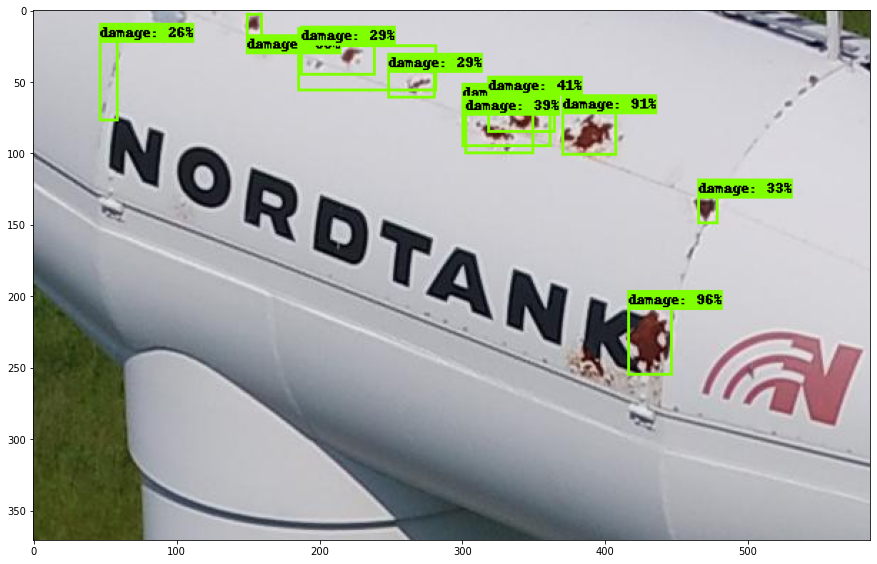

In [40]:
path2images_ = ['./test_images/DJI_0006_03_05.png']
inference_with_plot(path2images_)